<a href="https://colab.research.google.com/github/sk2003hw/Survival-Analysis/blob/main/STAT537.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats
import statsmodels.stats.proportion as proportion
import mlxtend.feature_selection
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_learning_curves

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final_Bone_Marrow_Bucketting.csv") # reading the processed csv file into a dataframe

In [ ]:
data.head() # glimpse of the data

,Donorage,RecipientRh,ABOmatch,CMVstatus,DonorCMV,RecipientCMV,HLAmatch,Antigen,Allele,HLAgrI,...,Recipientgender_1,Stemcellsource_1,IIIV_1,Gendermatch_1,Riskgroup_1,Txpostrelapse_1,Diseasegroup_1,Relapse_1,aGvHDIIIIV_1,survival_status
0,3.128081,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1,1,1,0,1,0,1,0,0,0
1,3.150274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,1,1,1,1
2,3.273156,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,1,1,1,1
3,3.680972,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,1,0,0,1
4,3.507325,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,0,1,0,0,1,0,1,0,1,0


## Preprocessing for Modelling

In [ ]:
data.info() # to check for missing values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Donorage           187 non-null    float64
 1   RecipientRh        187 non-null    float64
 2   ABOmatch           187 non-null    float64
 3   CMVstatus          187 non-null    float64
 4   DonorCMV           187 non-null    float64
 5   RecipientCMV       187 non-null    float64
 6   HLAmatch           187 non-null    float64
 7   Antigen            187 non-null    float64
 8   Allele             187 non-null    float64
 9   HLAgrI             187 non-null    float64
 10  Recipientage       187 non-null    float64
 11  extcGvHD           187 non-null    float64
 12  CD34kgx10d6        187 non-null    float64
 13  CD3dkgx10d8        187 non-null    float64
 14  Rbodymass          187 non-null    float64
 15  ANCrecovery        187 non-null    int64  
 16  PLTrecovery        187 non

In [ ]:
# we noticed that categorical variables have at most 7 unique values all in range 0-6
# iterating over the columns to transform column datatypes
for col in data.columns:
    max_val = data[col].value_counts().keys().max()
    unique_values = data[col].nunique()  # Count the number of unique values in the column
    if (max_val <= 6) and (unique_values <= 7):
        data[col] = data[col].astype('category')  # Convert the column to categorical data type

print(data.dtypes)

Donorage              float64
RecipientRh          category
ABOmatch             category
CMVstatus            category
DonorCMV             category
RecipientCMV         category
HLAmatch             category
Antigen              category
Allele               category
HLAgrI               category
Recipientage          float64
extcGvHD             category
CD34kgx10d6           float64
CD3dkgx10d8           float64
Rbodymass             float64
ANCrecovery          category
PLTrecovery          category
survival_time         float64
Recipientgender_1    category
Stemcellsource_1     category
IIIV_1               category
Gendermatch_1        category
Riskgroup_1          category
Txpostrelapse_1      category
Diseasegroup_1       category
Relapse_1            category
aGvHDIIIIV_1         category
survival_status      category
dtype: object


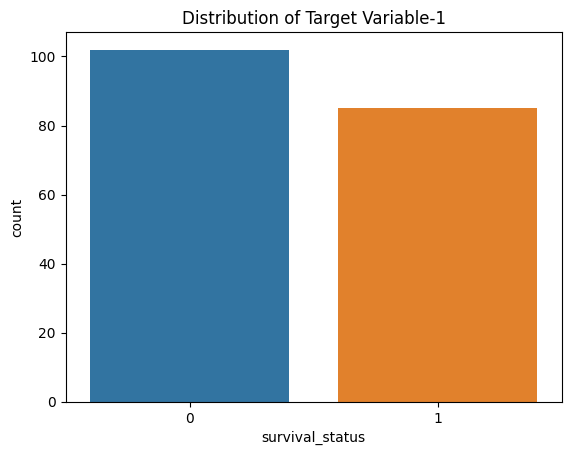

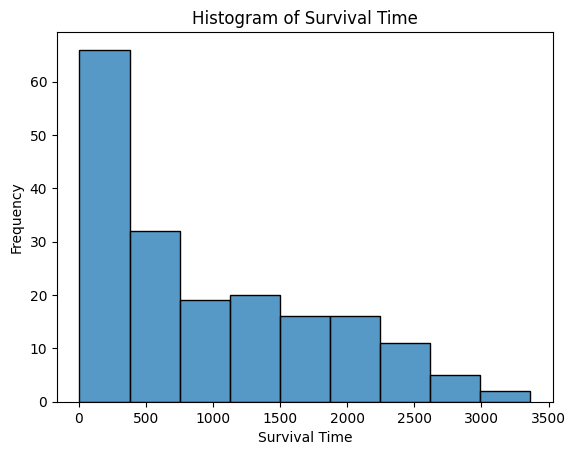

In [ ]:
# Binary Outcome
# distribution of the target variable
sns.countplot(data=data, x='survival_status')
plt.title('Distribution of Target Variable-1')
plt.show()

# For distb.
sns.histplot(data['survival_time'])
plt.xlabel('Survival Time')
plt.ylabel('Frequency')
plt.title('Histogram of Survival Time')
plt.show()

In [ ]:
# creating X and y datasets with the features and target attriutes
X = data.drop(['survival_status', 'survival_time'], axis=1)
y_status = data['survival_status']
y_time = data['survival_time']

In [ ]:
X.shape # printing the dimensions

(187, 26)

In [ ]:
y_status.shape

(187,)

In [ ]:
y_time.shape

(187,)

In [ ]:
count_status_1 = np.sum(data['survival_status'] == 1) # number of samples where survival status is 1 or alive
total_subjects = len(data['survival_status']) # total number of observations
proportion_status_1 = count_status_1 / total_subjects
print("Proportion of subjects with status = 1:", proportion_status_1)

se = np.sqrt(proportion_status_1 * (1 - proportion_status_1) / total_subjects)
print("Standard Error (SE):", se)

ci = proportion.proportion_confint(count_status_1, total_subjects, alpha=0.05, method='normal')
print("Confidence Interval (CI):", ci)

Proportion of subjects with status = 1: 0.45454545454545453
Standard Error (SE): 0.03641221839781041
Confidence Interval (CI): (0.38317881788853936, 0.5259120912023697)


In [ ]:
data['survival_status'].value_counts() # counts for each class of the target

0    102
1     85
Name: survival_status, dtype: int64

In [ ]:
X.shape

(187, 26)

In [ ]:
y_status.shape

(187,)

In [ ]:
X_train, X_test, y_time_train, y_time_test = train_test_split(X, y_time, test_size=0.2, random_state=0) # train-test splitting the dataset for the two functions

In [ ]:
print(X_train.shape)
print(X_test.shape)

(149, 26)
(38, 26)


In [ ]:
X_status_train, X_status_test, y_status_train, y_status_test = train_test_split(X, y_status, test_size=0.2, random_state=0)

<ipython-input-21-304e383cf865>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


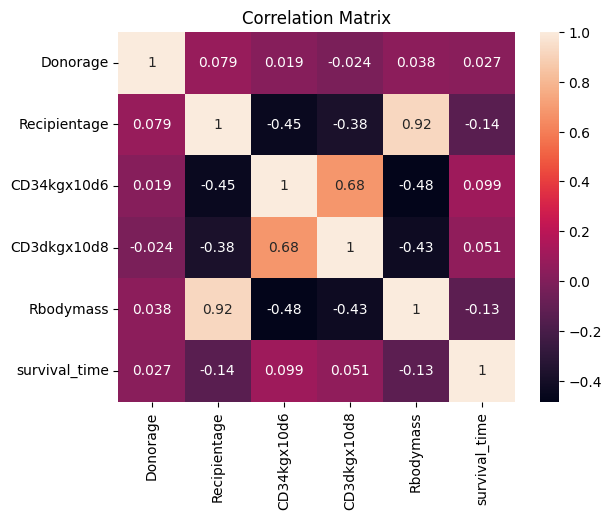

In [ ]:
# Checking Multicollinearity
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()

## Survival status

In [ ]:
def learn_curve(model):
    '''
      To draw learning curves
    '''
    plt.figure() # creating the figure to output
    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy")

    ts = np.linspace(0.1, 1.0, 10) # range of training sizes

    # computing the learning curve and mean rain and test scores
    train_sizes, train_scores, test_scores = learning_curve(model, X, y_status, train_sizes=ts)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # plotting the scores and the sample sizes for tain and test
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")
    plt.show()

In [ ]:
def featureselection(model, X_status_train1, y_status_train1):
  '''
    To select features from SequentialFeatureSelector for each model
  '''
  # backward eleimination for all features and the given model is fit and suitable features are outputted
  selector = SequentialFeatureSelector(model, direction='backward', scoring='accuracy', cv=10, n_features_to_select='auto', tol=None)
  selector.fit(X_status_train1, y_status_train1)
  selected_features = X_status_train1.columns[selector.get_support()]

  print("\nSelected features after backward elimination:")
  print(list(selected_features))
  return selected_features

### Logistic Regression

In [ ]:
def log_metrics(result, X_testing, y_testing):

  # Classification table
  y_status_pred = result.predict(sm.add_constant(X_testing)) # constant for the intercept
  y_status_pred_class = (y_status_pred > 0.5).astype(int) # threshold for correct classification is 0.5

  conf_mat = pd.crosstab(y_testing, y_status_pred_class, rownames=['Actual'], colnames=['Predicted'])
  print('Confusion Matrix:')
  print(conf_mat)

  print("\n",classification_report(y_testing, y_status_pred_class))


In [ ]:
def logreg(X_training, X_testing, y_training, y_testing):

  logit_model = sm.Logit(y_training, sm.add_constant(X_training)) # logistic regression model
  result = logit_model.fit(maxiter=10000)
  print(result.summary())

  # testing training
  print("For training data:")
  log_metrics(result, X_training, y_training)
  print('*'*50)

  # testing the model
  print("For testing data:")
  log_metrics(result, X_testing, y_testing)
  print('*'*50)

  # calculating the deviance (Likelihood Ratio Test)
  null_model = sm.Logit(y_testing, sm.add_constant(np.ones_like(y_testing)))
  null_result = null_model.fit()

  deviance = -2 * (null_result.llf - result.llf)
  p_value = 1 - stats.chi2.cdf(deviance, result.df_model)

  print('Deviance (Likelihood Ratio Test):')
  print('Deviance:', deviance)
  print('p-value:', p_value)
  print('*'*100)

  # Wald's test
  walds_test = result.wald_test_terms(scalar=False)
  print('\nWald\'s Test:')
  print(walds_test)

  learn_curve(LogisticRegression(max_iter=10000, C=0.1))

  return result

         Current function value: 0.416474
         Iterations: 10000
                           Logit Regression Results                           
Dep. Variable:        survival_status   No. Observations:                  149
Model:                          Logit   Df Residuals:                      122
Method:                           MLE   Df Model:                           26
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.3934
Time:                        23:31:58   Log-Likelihood:                -62.055
converged:                      False   LL-Null:                       -102.31
Covariance Type:            nonrobust   LLR p-value:                 1.752e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                21.8085   2.94e+06   7.42e-06      1.000   -5.76e+06    5.76e+06
Donorage              1.6332      1.126  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         chi2                  P>chi2  df constraint
const               [[5.507416777372648e-11]]      0.9999940787413373              1
Donorage               [[2.1020110649040937]]     0.14710554321619818              1
RecipientRh            [[2.7509228554429788]]     0.09719831254809713              1
ABOmatch              [[0.09471382768810216]]      0.7582679152760617              1
CMVstatus            [[0.000475737775229027]]      0.9825983893980016              1
DonorCMV              [[0.06289889522079571]]       0.801971431051018              1
RecipientCMV          [[0.00398274140583886]]      0.9496797358567537              1
HLAmatch               [[0.3259453598971426]]      0.5680564178671794              1
Antigen               [[0.02316292209993435]]      0.8790341633231659              1
Allele                 [[1.7013477519911173]]     0.19211181483494427              1
HLAgrI              [[0.0001584077249823693]]      0.989958079610

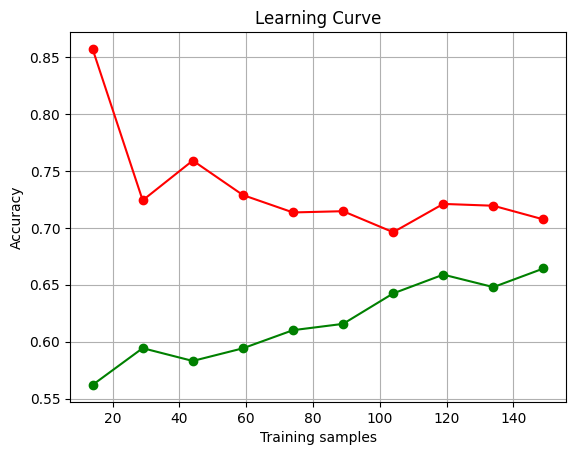

Selected features based on p-values:
['extcGvHD', 'Relapse_1', 'aGvHDIIIIV_1']


In [ ]:
result = logreg(X_status_train, X_status_test, y_status_train, y_status_test)
print(result)

# selection of signigicant features based on p-value
p_values = result.pvalues[1:]  # to exclude the intercept term
selected_features1 = X_status_train.columns[p_values < 0.05]

print("Selected features based on p-values:")
print(list(selected_features1))

Optimization terminated successfully.
         Current function value: 0.612072
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        survival_status   No. Observations:                  149
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.1086
Time:                        23:32:35   Log-Likelihood:                -91.199
converged:                       True   LL-Null:                       -102.31
Covariance Type:            nonrobust   LLR p-value:                 5.880e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9363      0.537      1.744      0.081      -0.116       1.989
extcGvHD        -0.9374

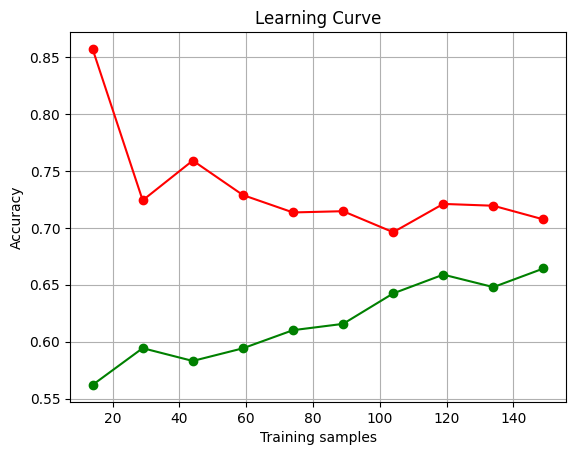

In [ ]:
# the X sets are subsetted to work with the selected features only
subset_X_train = X_status_train.loc[:, list(selected_features1)]
subset_X_test = X_status_test.loc[:, list(selected_features1)]
result = logreg(subset_X_train, subset_X_test, y_status_train, y_status_test)
print(result)


Selected features after backward elimination:
['DonorCMV', 'RecipientCMV', 'Antigen', 'Recipientage', 'extcGvHD', 'CD34kgx10d6', 'CD3dkgx10d8', 'PLTrecovery', 'Recipientgender_1', 'IIIV_1', 'Gendermatch_1', 'Riskgroup_1', 'Relapse_1']
         Current function value: 0.469146
         Iterations: 10000
                           Logit Regression Results                           
Dep. Variable:        survival_status   No. Observations:                  149
Model:                          Logit   Df Residuals:                      135
Method:                           MLE   Df Model:                           13
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.3167
Time:                        23:33:32   Log-Likelihood:                -69.903
converged:                      False   LL-Null:                       -102.31
Covariance Type:            nonrobust   LLR p-value:                 7.142e-09
                        coef    std err          z      P>|z|  

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


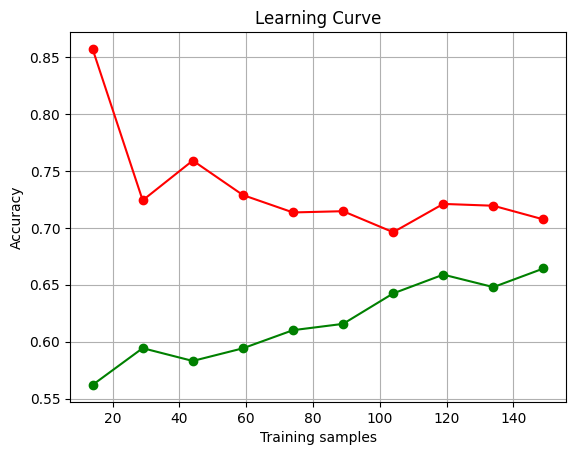

In [ ]:
# selecting purely from the sequnetial feature selector
log_model = LogisticRegression(max_iter=10000, C=0.1)
selected_features = featureselection(log_model, X_status_train, y_status_train)

subset_X_train = X_status_train.loc[:, list(selected_features)]
subset_X_test = X_status_test.loc[:, list(selected_features)]
result = logreg(subset_X_train, subset_X_test, y_status_train, y_status_test)
print(result)

### Decision Tree

In [ ]:
# parameter grid for the grid search
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 20, 25],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, params_grid, cv=10)
grid_search.fit(X_status_train, y_status_train)

best_params = grid_search.best_params_
print(best_params)

{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [ ]:
def decision_tree(params, X_training, X_testing, y_training, y_testing, flag):

  # Fitting the decision tree
  dt = DecisionTreeClassifier(**params)
  dt.fit(X_training, y_training)

  # predictions on the testing data
  y_pred1 = dt.predict(X_training)
  # classification report
  print("For training data:")
  print(classification_report(y_training, y_pred1))
  print('*'*100)

  # predictions on the testing data
  y_pred2 = dt.predict(X_testing)
  # classification report
  print("For testing data:")
  print(classification_report(y_testing, y_pred2))
  print('*'*100)

  # decision tree visualization
  plt.figure(figsize=(10, 10))
  plot_tree(dt, filled=True, feature_names=X_training.columns, class_names=['0', '1'])
  plt.show()

  learn_curve(dt)

  if flag==1:
    return featureselection(dt, X_training, y_training)

  return None


For training data:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        83
           1       0.82      0.70      0.75        66

    accuracy                           0.80       149
   macro avg       0.80      0.79      0.79       149
weighted avg       0.80      0.80      0.80       149

****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.62      0.84      0.71        19
           1       0.75      0.47      0.58        19

    accuracy                           0.66        38
   macro avg       0.68      0.66      0.65        38
weighted avg       0.68      0.66      0.65        38

****************************************************************************************************


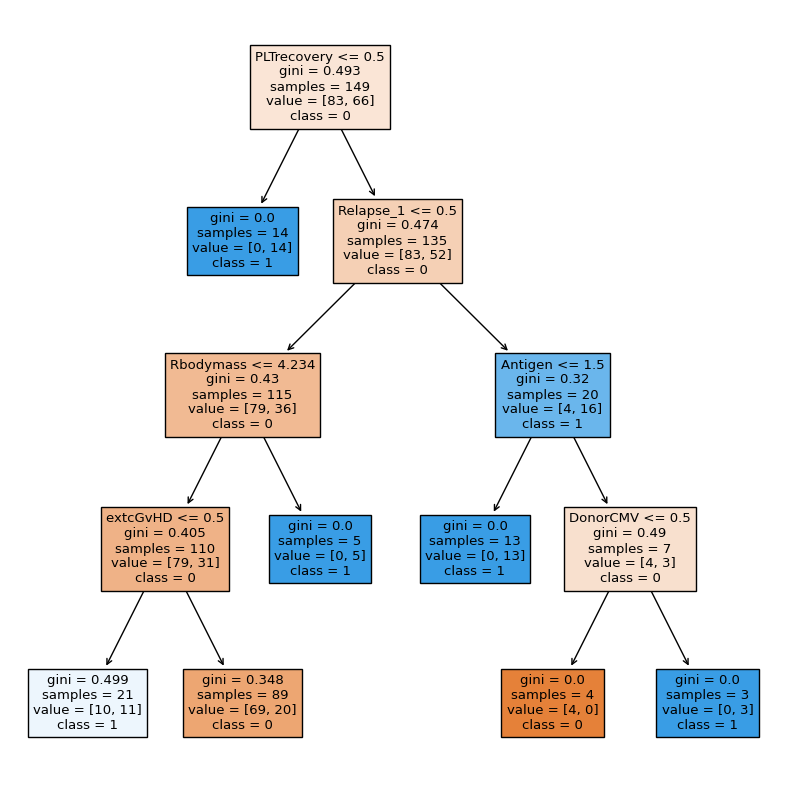

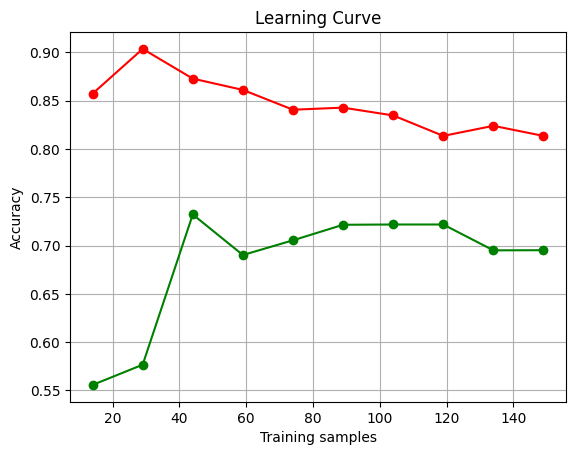


Selected features after backward elimination:
['DonorCMV', 'Antigen', 'Allele', 'extcGvHD', 'ANCrecovery', 'PLTrecovery', 'Recipientgender_1', 'IIIV_1', 'Gendermatch_1', 'Riskgroup_1', 'Txpostrelapse_1', 'Diseasegroup_1', 'Relapse_1']


In [ ]:
# Fitting the decision tree with the best parameters
selected_features = decision_tree(best_params, X_status_train, X_status_test, y_status_train, y_status_test, 1)

Best parameters:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
******************************************************************************************************************************************************
For training data:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87        83
           1       1.00      0.64      0.78        66

    accuracy                           0.84       149
   macro avg       0.89      0.82      0.83       149
weighted avg       0.88      0.84      0.83       149

****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.60      0.95      0.73        19
           1       0.88      0.37      0.52        19

    accuracy                           0.66        38
   macro avg       0.74      0.66      0.63        38
weighte

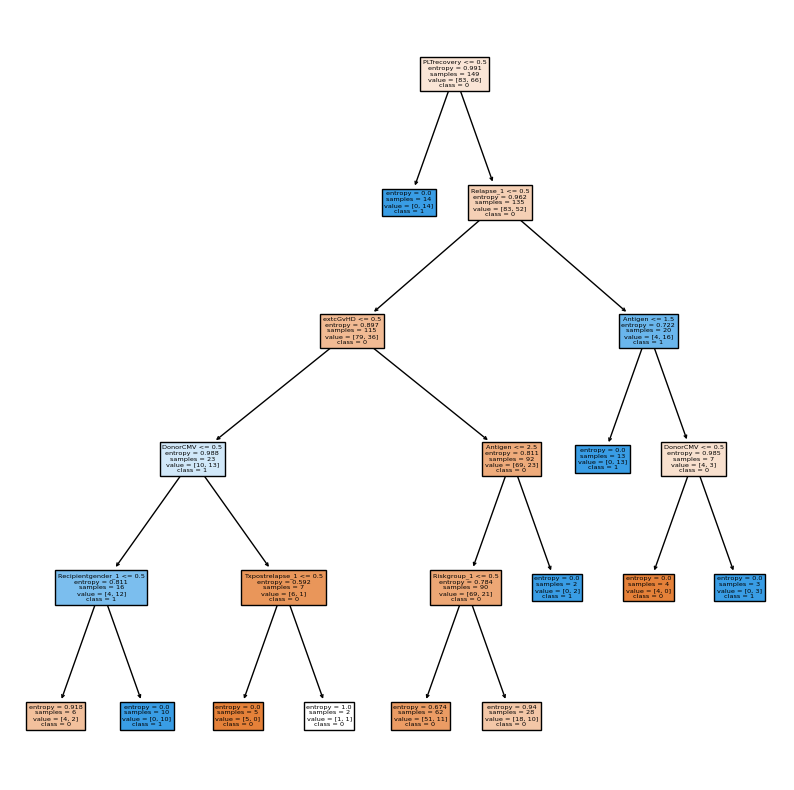

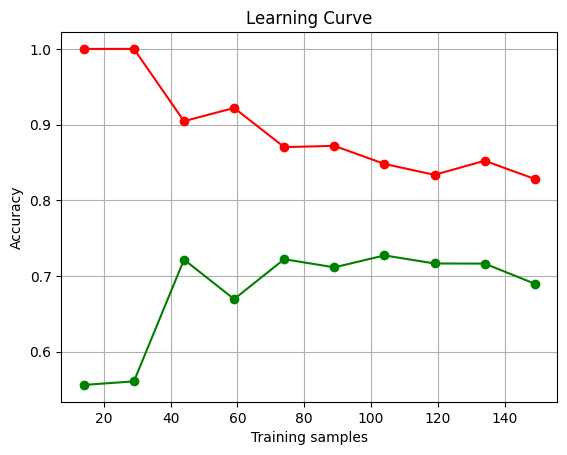

In [ ]:
subset_X_train = X_status_train.loc[:, list(selected_features)]
subset_X_test = X_status_test.loc[:, list(selected_features)]

# parameter grid for the grid search
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 20, 25],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, params_grid, cv=10)
grid_search.fit(subset_X_train, y_status_train)

best_params = grid_search.best_params_
print("Best parameters:")
print(best_params)
print('*'*150)

decision_tree(best_params, subset_X_train, subset_X_test, y_status_train, y_status_test, 0)

### SVM

In [ ]:
# For grid search
params_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), params_grid, cv=10)
grid_search.fit(X_status_train, y_status_train)
best_params = grid_search.best_params_
print(best_params)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [ ]:
def SVM(params, X_training, X_testing, y_training, y_testing, flag):

  svm_classifier = SVC(**params) # instance of SVM classifier
  svm_classifier.fit(X_training, y_training)  # Fitting the SVM classifier to the training data

  # predictions on the testing data
  y_pred1 = svm_classifier.predict(X_training)
  # classification report
  print("For training data:")
  print(classification_report(y_training, y_pred1))
  print('*'*100)

  # predictions on the testing data
  y_pred2 = svm_classifier.predict(X_testing)
  # classification report
  print("For testing data:")
  print(classification_report(y_testing, y_pred2))
  print('*'*100)

  learn_curve(svm_classifier)

  if flag==1:
    return featureselection(svm_classifier, X_training, y_training)

  return None

For training data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        83
           1       0.90      0.82      0.86        66

    accuracy                           0.88       149
   macro avg       0.88      0.87      0.88       149
weighted avg       0.88      0.88      0.88       149

****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        19
           1       0.85      0.58      0.69        19

    accuracy                           0.74        38
   macro avg       0.76      0.74      0.73        38
weighted avg       0.76      0.74      0.73        38

****************************************************************************************************


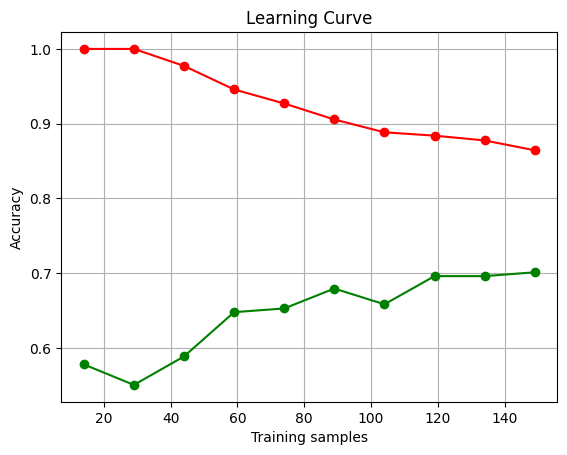


Selected features after backward elimination:
['ABOmatch', 'DonorCMV', 'RecipientCMV', 'Allele', 'Recipientage', 'extcGvHD', 'CD34kgx10d6', 'CD3dkgx10d8', 'Rbodymass', 'PLTrecovery', 'Stemcellsource_1', 'Relapse_1', 'aGvHDIIIIV_1']


In [ ]:
# Fitting the SVM with the best parameters
selected_features = SVM(best_params, X_status_train, X_status_test, y_status_train, y_status_test,1)

Best parameters:
{'C': 1000, 'gamma': 1, 'kernel': 'linear'}
******************************************************************************************************************************************************
For training data:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        83
           1       0.78      0.68      0.73        66

    accuracy                           0.77       149
   macro avg       0.77      0.76      0.77       149
weighted avg       0.77      0.77      0.77       149

****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        19
           1       0.85      0.58      0.69        19

    accuracy                           0.74        38
   macro avg       0.76      0.74      0.73        38
weighted avg       0.76      0.74      0.73        

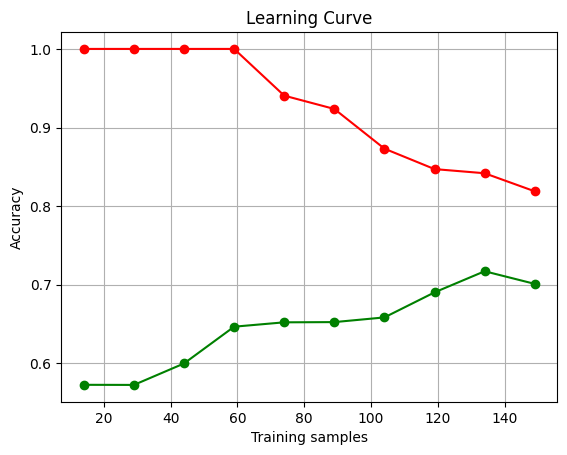

In [ ]:
subset_X_train = X_status_train.loc[:, list(selected_features)]
subset_X_test = X_status_test.loc[:, list(selected_features)]

# parameter grid for the grid search
params_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'sigmoid']
}

grid_search = GridSearchCV(SVC(), params_grid, cv=10)
grid_search.fit(subset_X_train, y_status_train)
best_params = grid_search.best_params_
print("Best parameters:")
print(best_params)
print('*'*150)

SVM(best_params, subset_X_train, subset_X_test, y_status_train, y_status_test,0)

### XGBoost

In [ ]:
# Define the hyperparameter grid
params_grid = {
    'max_depth': range(2,20),
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.3, 0.5, 0.7, 0.8, 0.9, 1]
}

grid_search = GridSearchCV(XGBClassifier(objective= "binary:logistic", enable_categorical='True'), params_grid, cv=10, scoring='accuracy')
grid_search.fit(X_status_train, y_status_train)
best_params = grid_search.best_params_
print("Best parameters:")
print(best_params)

Best parameters:
{'learning_rate': 0.1, 'max_depth': 4, 'subsample': 0.7}


In [ ]:
def XGB(params, X_training, X_testing, y_training, y_testing, flag):

  xgbc = XGBClassifier(**params, enable_categorical='True', objective= "binary:logistic") # instance of SVM classifier
  xgbc.fit(X_training, y_training)  # Fitting the SVM classifier to the training data

  # predictions on the testing data
  y_pred1 = xgbc.predict(X_training)
  # classification report
  print("For training data:")
  print(classification_report(y_training, y_pred1))
  print("RMSE= ", np.sqrt(mean_squared_error(y_training, y_pred1)))
  print('*'*100)

  # predictions on the testing data
  y_pred2 = xgbc.predict(X_testing)
  # classification report
  print("For testing data:")
  print(classification_report(y_testing, y_pred2))
  print("RMSE= ", np.sqrt(mean_squared_error(y_testing, y_pred2)))
  print('*'*100)

  # Plot feature importance
  xgb.plot_importance(xgbc)
  plt.show()

  learn_curve(xgbc)

  if flag==1:
    return featureselection(xgbc, X_training, y_training)

  return None

For training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        66

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149

RMSE=  0.0
****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.92      0.63      0.75        19

    accuracy                           0.79        38
   macro avg       0.82      0.79      0.78        38
weighted avg       0.82      0.79      0.78        38

RMSE=  0.45883146774112354
****************************************************************************************************


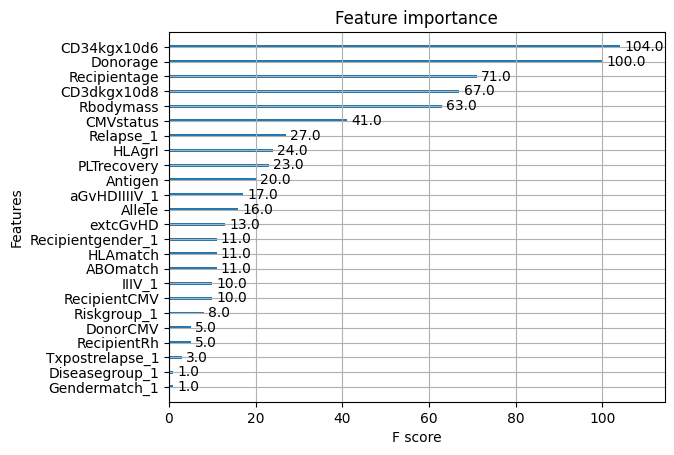

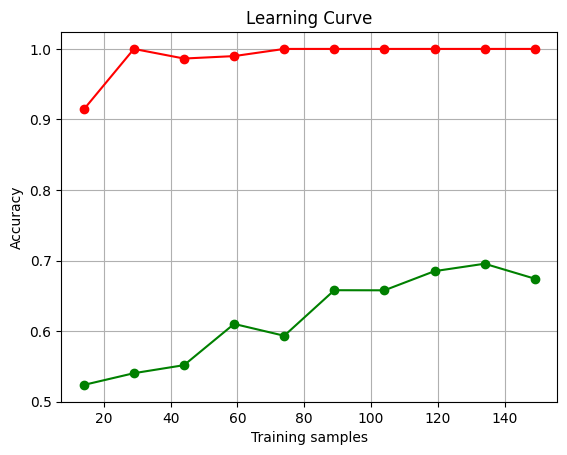


Selected features after backward elimination:
['RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'HLAgrI', 'Recipientage', 'extcGvHD', 'CD34kgx10d6', 'Rbodymass', 'PLTrecovery', 'IIIV_1', 'Relapse_1', 'aGvHDIIIIV_1']


In [ ]:
# Fitting the SVM with the best parameters
selected_features = XGB(best_params, X_status_train, X_status_test, y_status_train, y_status_test,1)

Best parameters:
{'learning_rate': 0.1, 'max_depth': 7, 'subsample': 1}
******************************************************************************************************************************************************
For training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        83
           1       1.00      1.00      1.00        66

    accuracy                           1.00       149
   macro avg       1.00      1.00      1.00       149
weighted avg       1.00      1.00      1.00       149

RMSE=  0.0
****************************************************************************************************
For testing data:
              precision    recall  f1-score   support

           0       0.67      0.84      0.74        19
           1       0.79      0.58      0.67        19

    accuracy                           0.71        38
   macro avg       0.73      0.71      0.71        38
weighted avg       0.73      

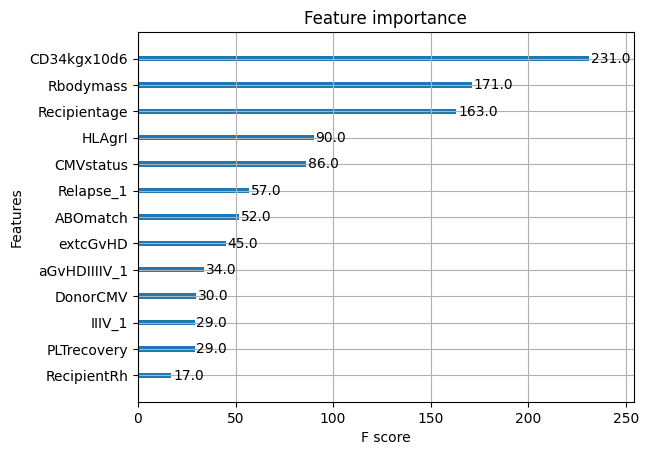

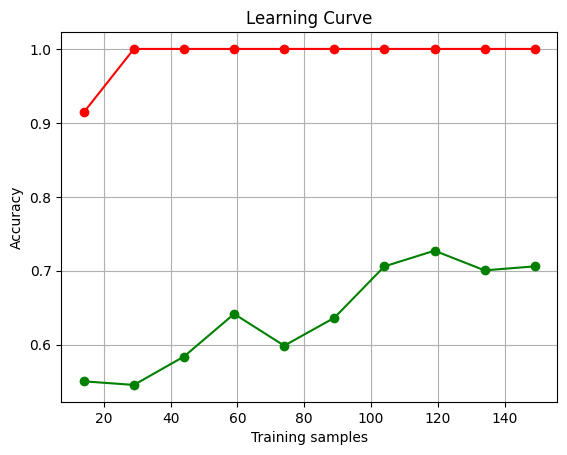

In [ ]:
subset_X_train = X_status_train.loc[:, list(selected_features)]
subset_X_test = X_status_test.loc[:, list(selected_features)]

# parameter grid for the grid search
params_grid = {
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

grid_search = GridSearchCV(XGBClassifier(enable_categorical='True', objective= "binary:logistic"), params_grid, cv=10)
grid_search.fit(subset_X_train, y_status_train)
best_params = grid_search.best_params_
print("Best parameters:")
print(best_params)
print('*'*150)

XGB(best_params, subset_X_train, subset_X_test, y_status_train, y_status_test,0)

## Survival Time

In [ ]:
# Fitting the entire linear regression model for reference
model1 = sm.OLS(y_time_train, sm.add_constant(X_train)).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:          survival_time   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     1.930
Date:                Wed, 06 Dec 2023   Prob (F-statistic):            0.00919
Time:                        02:20:03   Log-Likelihood:                -1188.7
No. Observations:                 149   AIC:                             2431.
Df Residuals:                     122   BIC:                             2513.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -184.3481   1441.25

In [ ]:
data_subset = data[(data['aGvHDIIIIV_1'] == 1) & (data['extcGvHD'] == 1) & (data['Relapse_1'] == 0)] # subset of data where the undesirable events affecting patients' quality of life are none

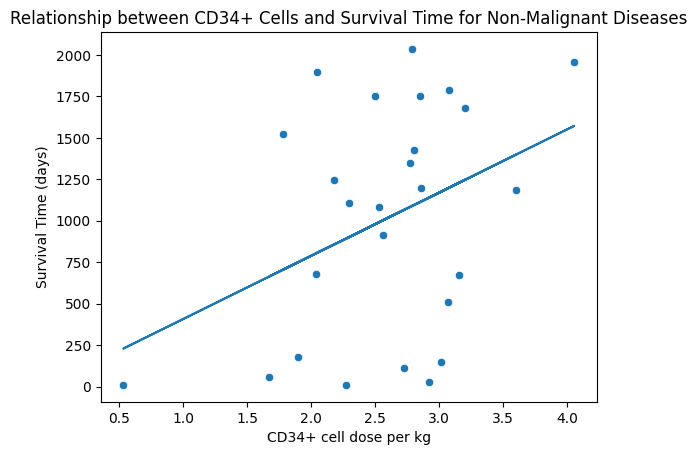

In [ ]:
# plotting the relation between the CD34+ cells with survival time for non-malignant diseases
x = data_subset[data_subset['Diseasegroup_1'] == 0]['CD34kgx10d6']
y = data_subset[data_subset['Diseasegroup_1'] == 0]['survival_time']
a, b = np.polyfit(x,y,1) # linear regression on the data points, to get the slope and the y-intercept

# data points are added to the plot
sns.scatterplot(x=x, y=y)

# find line of best fit
plt.plot(x, a*x+b)
plt.title('Relationship between CD34+ Cells and Survival Time for Non-Malignant Diseases')
plt.xlabel('CD34+ cell dose per kg')
plt.ylabel('Survival Time (days)')
plt.show()

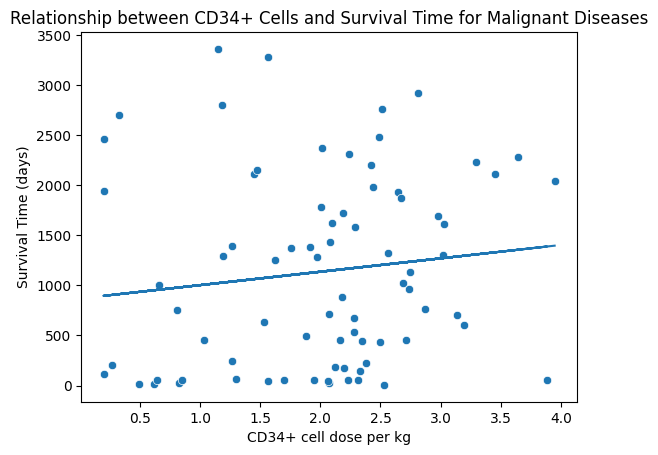

In [ ]:
# plotting the relation between the CD34+ cells with survival time for malignant diseases
x = data_subset[data_subset['Diseasegroup_1'] == 1]['CD34kgx10d6']
y = data_subset[data_subset['Diseasegroup_1'] == 1]['survival_time']
a, b = np.polyfit(x,y,1) # linear regression on the data points, to get the slope and the y-intercept

# data points are added to the plot
sns.scatterplot(x=x, y=y)

# find line of best fit
plt.plot(x, a*x+b)
plt.title('Relationship between CD34+ Cells and Survival Time for Malignant Diseases')
plt.xlabel('CD34+ cell dose per kg')
plt.ylabel('Survival Time (days)')
plt.show()